In [58]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

**Leakage detection in a water reservoir**


---



Artificial water reservoirs are commonly used to collect, store, and manage water for various purposes, including public supply of drinking water, irrigation, industrial use, hydroelectric power generation, flood control and more. For companies utilizing artificial water reservoirs, such as tanks and cisterns, proper maintenance is essential to prevent issues like water leaks and other potential mishaps.

Our purpose, here, is to come up with an efficient algorithm that can rapidly detect potential water leaks based on real-time measurements of the pressure field. To simplify, we consider a 2D section of a cylindrical cistern, consisting of a main core, $R = \{(x, y) : x^2 + y^2 \leq 0.5^2\} \subset \mathbb{R}^2$, surrounded by an emergency wall, $\Gamma = \{(x, y) : x^2 + y^2 = 1\}$. We refer to Figure \boxed{1} for a visual representation. In order to develop suitable safety measures, we are interested in studying the worst case scenario, that is, the unfortunate event in which water manages to break out of both the reservoir and the emergency wall. We use the steady Navier-Stokes equations to model the fluid flow, ideally capturing the scenario a few minutes after the break has occurred.

Let $\Omega = \{(x, y) : 0.5^2 < x^2 + y^2 < 1\}$ be the interspace between the reservoir and the emergency wall. Let $u : \Omega \to \mathbb{R}^2$ and $p : \Omega \to \mathbb{R}$ be the velocity field and the pressure field of the fluid, respectively. Let $z_1 \in \partial R$ and $z_2 \in \Gamma$ be the break points on the two surfaces, respectively centered at $z_1$ and $z_2$. We model $u$ and $p$ as the solution to the following Navier-Stokes equations

$$
\begin{cases}
-\Delta u + u \cdot \nabla u - \nabla p = 0 & \text{in } \Omega \\
\nabla \cdot u = 0 & \text{in } \Omega
\end{cases} \quad (1)
$$

with boundary conditions,

$$
\begin{cases}
u(x, y) = [ \frac{1}{4} + y^2 - \rho_1^2, 0 ]^T & \forall (x, y) \in R : ||(x, y) - z_1|| < \rho_1 \\
p(x, y) = 0 & \forall (x, y) \in \Gamma : ||(x, y) - z_2|| < \rho_2 \\
u = 0 & \text{elsewhere on } \partial \Omega.
\end{cases} \quad (2)
$$

modeling inflow, outflow and no-slip conditions, respectively. Given all the rotational symmetries enjoyed by Eqs. \boxed{1}-\boxed{2}, we shall fix the position of the first break point, $z_1 = [0.5, 0]$. Instead, we allow $z_2, \rho_1, \rho_2$, to change as

$$
0.05 \leq \rho_1 \leq 0.1, \quad z_2 = [\cos\theta, \sin\theta]^T \text{ with } \theta \in [0, \pi].
$$



Let $P := [\theta, \rho_1, \rho_2]^T$ be the problem parameters. You are given access to a dataset of $N = 200$ pre-computed random simulations of the pressure field, obtained for different values of the problem parameters, $\{\mu_j, p_{\mu_j}\}_{j=1}^N$. The dataset was constructed by drawing random values for $\mu$ (independently and uniformly in the parameter space) and then solving \boxed{1} using a Finite Element solver. Only the pressure fields were stored, with each PDE solution being represented as a discrete vector, $p_{\mu_j} \approx P\mu_j$, with $N_h = 3899$ degrees of freedom.
Additionally, you are also given access to a dataset of 8 sensor measurements coming from an unknown pressure field $p_s : \Omega \to \mathbb{R}$. These correspond to pressure values recorded at the outer boundary,

$$
[s_1, \dots, s_k] = [p_s(x_1, y_1), \dots, p_s(x_8, y_8)]
$$

with $(x_k, y_k) = (\cos k\frac{\pi}{4}, \sin k\frac{\pi}{4})$. Ideally, we would like to use the simulations provided and the sensor measurements to solve the inverse problem, that is, to recover the values $\theta, \rho_1, \rho_2$ associated to $[s_1, \dots, s_k]^T$. If we succeed, we will be able to estimate the position and the width of a water leak using as little as 8 sensor measurements.

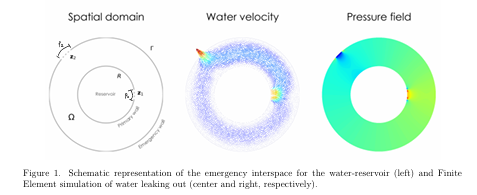

In [59]:
# Import of pre-computed data

# FOM discretization
import gdown # Library to download a file from Google Drive using its unique ID
gdown.download(id = "1PrQyfLv3Sjv8oOgZk48MR-miDAq0X4pO", output = "leak_mesh.xml") # download the mesh
mesh = fe.loadmesh("leak_mesh.xml") # load the mesh, i.e. geometry and discretization
Vh = fe.space(mesh, 'CG', 1) # define the function space where the solution will be searched. CG = continuous Galerkin, 1 is the degree of the shape function - they will be used to create functions starting from the points of the mesh
clc()

# Dataset (parameters and u fields)
gdown.download(id = "1eEtqZPjLe3xPed15ckTAGNBYDQ8px8aJ", output = "leak_data.npz")
clc()
dataset = np.load("leak_data.npz") # download the pressure fields for different sets of parameters
mu, u = dataset['mu'], dataset['u']

# Pressure measurements for the inverse problem
gdown.download(id = "1STu-gV96oB4Gqtv-kf9aenXODqJ7kdIq", output = "sensor_measurements.npz")
clc()
measurements = np.load("sensor_measurements.npz")
sensors_location, sensors_values = measurements['sensor_indices'], measurements['pressure_measurements'] # sensor_location indicates the DOF on the mesh where the sensor is placed, while sensor_values gives the pressure measured by that sensor

# Print info about imported data
print(f"Number of simulations: {u.shape[0]}")
print(f"Number of DOFs (FOM): {u.shape[1]}")
print(f"Shape of mu (parameters): {mu.shape}")         # Should be (num_simulations, 3)
print(f"Shape of u (solutions): {u.shape}")            # Should be (num_simulations, num_dofs)

# Print sensor locations and their corresponding measurements
print(f"\nSensor positions (DOF indices): {sensors_location}")
print(f"Pressure measurements at sensors: {sensors_values}")

# sensor 1 and 8 coincides

Number of simulations: 200
Number of DOFs (FOM): 3899
Shape of mu (parameters): (200, 3)
Shape of u (solutions): (200, 3899)

Sensor positions (DOF indices): [   4 1285 2586 3594 3833 2697 1139    4]
Pressure measurements at sensors: [0.74090497 0.555422   0.40491081 0.44736759 0.51212018 0.57835533
 0.64417083 0.74090497]


**Point 1** - finding the simulation that best fit the measurements


---


To start, find the simulation in the dataset that best fits the measurements, that is

$$
i_s = \operatorname{argmin}_{i=1, \dots, 200} \left\{ \sum_{k=1}^8 [s_k - p_{\mu_i}(x_k, y_k)]^2 \right\} = \operatorname{argmin}_{i=1, \dots, 200} \left\{ \sum_{k=1}^8 [s_k - p_{\mu_i}^{(j_k)}]^2 \right\},
$$


where $p_{\mu_i} = [p_{\mu_i}^{(1)}, \dots, p_{\mu_i}^{(N_h)}]^T$ and $j_1, \dots, j_8$ are suitable indices extracting the degrees of freedom associated to the sensors location. Which are the problem parameters associated to such simulation?

As a next step, we would to improve our estimate at point (a) by fitting a reduced order model over the data provided (rather than just using the dataset as an "atlas" for possible scenarios).

In [60]:
# Finding the simulation that best fit the data

error_vector = np.zeros(u.shape[0])

for i in range(u.shape[0]):
    simulation_values = u[i, sensors_location]  # extract pressure values at sensor locations for the current simulation
    error_vector[i] = np.sum((simulation_values - sensors_values)**2)  # calculate difference between simulation and real data

best_simulation = np.argmin(error_vector)  # find simulation with the smallest error
best_mu = mu[best_simulation, :]

print('Best simulation is the number ' + str(best_simulation) + ', with parameters (theta, p1, p2): ' + str(best_mu))
print(f'\nError: {error_vector[best_simulation]:.6f}')

Best simulation is the number 67, with parameters (theta, p1, p2): [2.15479511 0.07729257 0.09294283]

Error: 0.003633


**Point 2** - Implementing the POD-NN ROM


---

Design and train a suitable ROM of your choice (POD-NN or DL-ROM) to approximate the map

$$
\mathbb{R}^3 \ni \mu \mapsto p_\mu \in \mathbb{R}^{3899}.
$$

To this end, only use 150 simulations for training, keeping 50 for the testing phase. In the $L^2$ norm, what is the average relative error of your model over the test set? You may consider the ROM satisfactory if the latter is \textbf{below 12\%}.


---



Error function that we will use:

$E = \frac{1}{N_{test}}\sum_{i}\left(\frac{\left\|u_{i}-\tilde{u}_{i}\right\|_{L^{2}(\Omega)}}{\left\|u_{i}\right\|_{L^{2}(\Omega)}}\right)$

where $\left\|\cdot\right\|_{L^{2}(\Omega)}$ is the $L^{2}$-norm, whereas the index $i$ runs along the trajectories in the test set.

In [61]:
# define the operator to calculate the integral norm (for error calculation)
l2 = L2(Vh)
l2.cuda()
clc()

# define function for error calculation
def error(utrue, upred):
    return (l2(utrue-upred)/l2(utrue)).mean()

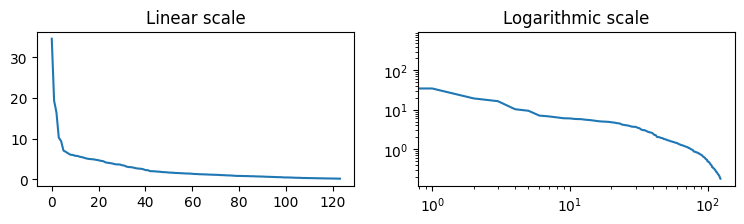

In [62]:
# Find POD basis

ntrain = 150

from scipy.linalg import svd
X, s, Yt = svd(u[:ntrain].T, full_matrices = False) # SVD of snapshots: u[:ntrain].T -> i consider only up to the 150-th simulation, and transpose for dimensionality matching

plt.figure(figsize = (9, 2))
plt.subplot(1,2,1)
plt.title("Linear scale")
plt.plot(s[1:125]) # plot singular values on linear scale - in linear scale i skip the first singular values because it lives in a different scale
plt.subplot(1,2,2)
plt.title("Logarithmic scale")
plt.loglog(s[:125]) # plot singular values on logarithmic scale
plt.show()

In [63]:
# choice of number of singular values, RB dimensions

n = 66 # we have a total of 150 singular values. I would select the minimum number (66 singular values) in order to obtain projection error below 1%
V = X[:, :n]
V.shape

(3899, 66)

In [64]:
# computing the projection error (with test set)

mu, u, V = dv.tensor(mu, u, V) # convert to tensors for later use with the network

uproj = u @ V @ V.T # find approximate solution from POD
avg_proj_error = error(u[ntrain:], uproj[ntrain:])
print("Average projection error: %s." % num2p(avg_proj_error))

Average projection error: 0.98%.


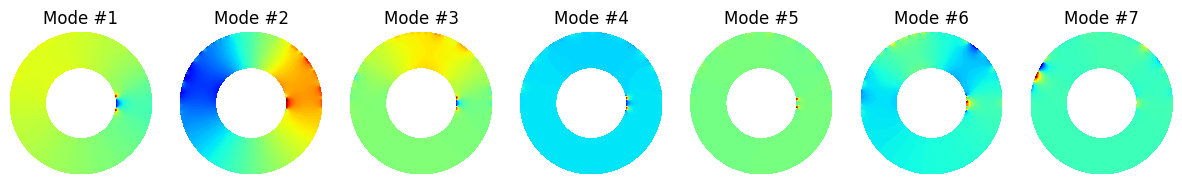

In [65]:
# plotting the first 7 basis functions

plt.figure(figsize = (15, 8)) # visualize the first elements of the base. Making a linear combinations i can get the FOM solutions
for k in range(7):
  plt.subplot(1, 7, k+1)
  fe.plot(V[:, k], Vh)
  plt.title(f"Mode #{k+1}")
plt.show()

In [66]:
# load pre-trained model, phi, which maps parameters mu (p-dimensional) to reduced solution c (n-dimensional)

p = mu.shape[1]  # number of parameters (3)
phi = Dense(p, 10, gelu) + Dense(10, 10, gelu) + Dense(10, n, activation = None)
phi.load('phi.npz')
phi.cuda() # transfer to GPU
phi.eval()

print("Number of model parameters: %d" % int(phi.dof()))

uROM = phi(mu[ntrain:]) @ V.T  # ROM solutions (multiply coefficients given by network by basis, expand on basis), assemble pipeline seen in class - have to use V.T for dimensionality matching

# uncomment to train model

# NOTE: if I don't use Adam optimizer, doing it like lab 6, I get over 90% error

# from torch.optim import Adam

# c = u @ V  # compute coefficients of linear combination/compressed solution. Use these to train the network. Thus, assemble the dataset for the network
# p = mu.shape[1]  # number of parameters (3)

# phi = Dense(p, 10, gelu) + Dense(10, 10, gelu) + Dense(10, n, activation = None)  # neural network architecture: p inputs, 10 neurons hidden layer, n output (remember no activation at the end)
# model = DFNN(phi)  # set training mode
# model.He()  # remember to initialize
# model.cuda()  # transfer to GPU

# model.train(mu, c, ntrain = ntrain, epochs = 37, loss = mse(euclidean))  # use half of the data for training

# model.train(mu, c, ntrain = ntrain, epochs = 2000, loss = mse(euclidean),  # here we try Adam optimizer with batches of 64 "images"
#                   optim = Adam, lr = 1e-5, batchsize = 64)  # learning rate low as this is a "second phase" of training

# model.freeze()  # no need to change parameters, also saves memory by not storing unnecessary data

Number of model parameters: 876


In [67]:
print("Average relative error of POD-NN: %s." % num2p(error(u[ntrain:], uROM)))

Average relative error of POD-NN: 9.98%.


**Point 3** - Parameter inversion to obtain a better estimate of the parameters


---

Given any parameter vector $\mu$, let $\tilde{p}_\mu$ denote the approximation of the pressure field obtained through the surrogate model. Leveraging the ROM, estimate the model parameters associated with the sensor measurements by solving the following least-square problem

$$
\mu_{lt\_sq} := \operatorname{argmin}_{\mu \in \Theta} \sum_{k=1}^8 |s_k - \tilde{p}_{\mu_i}^{(j_k)}|^2,
$$

with $\Theta = [0, \pi] \times [0.05, 0.1]^2$ being the parameter space.

In [68]:
from scipy.optimize import minimize
import torch

V_numpy = V.cpu().numpy() if torch.is_tensor(V) else V  # convert V to NumPy for safety
rom_calls = 0

def rom_predict(mu_input):
    """
    Use the ROM model (POD-NN) to compute the pressure field given mu.
    """

    global rom_calls
    rom_calls += 1
    mu_tensor = torch.tensor(mu_input, dtype=torch.float32).unsqueeze(0).cuda() # convert into PyTorch tensor with type float32, add one dimension and move on GPU
    with torch.no_grad(): # deactivate tracking of the gradient since i'm not training the network anymore
        u_reduced = phi(mu_tensor).cpu().numpy()  # reduced coefficients, obtained through phi
    u_full = u_reduced @ V_numpy.T  # reconstruct on the POD basis (all NumPy)
    return u_full[0]

def error_function(mu_input):
    """
    Error function: difference between real measurements and ROM predictions at the sensors.
    """
    u_full = rom_predict(mu_input) # call to ROM solver
    prediction = u_full[sensors_location] # extraction of pressure in sensors positions
    error = np.sum((prediction - sensors_values)**2)  # error computed as above
    return error

In [69]:
from scipy.optimize import differential_evolution
from time import perf_counter

rom_calls = 0 # if i run multiple times this cell i want the counter to reset

bounds = [(0, np.pi), (0.05, 0.1), (0.05, 0.1)] # bounds: theta in [0, pi], rho1/rho2 in [0.05, 0.1]

t0 = perf_counter() # start timing the optimization process

result = differential_evolution(error_function, bounds)  # use global optimizer (no initial guesses passed) - leveraging on the ROM

t1 = perf_counter() # stop timing

# using local optimizer yields larger error than point 1
#from scipy.optimize import minimize
# initial_guess = best_mu.tolist() # Use the initial point from the best_simulation found earlier
# result = minimize(error_function, initial_guess, bounds=bounds, method='SLSQP')  # optimizer calls error function relying on ROM to find solution with those parameters

error_decrease = ((error_vector[best_simulation] - result.fun) / error_vector[best_simulation]) * 100 # compute relative improvement in error with respect to the best existing simulation

print("\n===== PARAMETER INVERSION RESULTS =====")
print(f"Optimal parameters found via ROM (POD-NN) + optimization:")
print(f"    theta: {result.x[0]:.9f} rad")
print(f"    rho1 : {result.x[1]:.9f}")
print(f"    rho2 : {result.x[2]:.9f}")
print(f"Error: {result.fun:.9f}")

print("\n--- Comparison with closest simulation in dataset (point 1) ---")
print(f"Closest simulation index: {best_simulation}")
print(f"Parameters (theta, rho1, rho2): {best_mu}")
print(f"Error: {error_vector[best_simulation]:.9f}\n")

print(f"ROM allowed achieving an error {(error_vector[best_simulation] / result.fun):.0f} times smaller")
print(f"Number of ROM evaluations during optimization: {rom_calls}")
print("Total optimization time: %.3fs" % (t1 - t0))
print("Average time per ROM evaluation: %.4f milliseconds" % (((t1 - t0) / rom_calls)*1000))


===== PARAMETER INVERSION RESULTS =====
Optimal parameters found via ROM (POD-NN) + optimization:
    theta: 2.199166813 rad
    rho1 : 0.050423531
    rho2 : 0.068172055
Error: 0.000408747

--- Comparison with closest simulation in dataset (point 1) ---
Closest simulation index: 67
Parameters (theta, rho1, rho2): [2.15479511 0.07729257 0.09294283]
Error: 0.003632724

ROM allowed achieving an error 9 times smaller
Number of ROM evaluations during optimization: 1479
Total optimization time: 0.993s
Average time per ROM evaluation: 0.6717 milliseconds


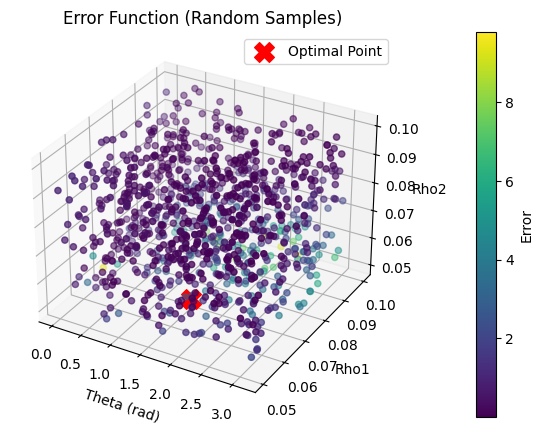

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

num_samples = 1000

# Randomly sample parameters within bounds
sampled_theta = np.random.uniform(bounds[0][0], bounds[0][1], num_samples)
sampled_rho1 = np.random.uniform(bounds[1][0], bounds[1][1], num_samples)
sampled_rho2 = np.random.uniform(bounds[2][0], bounds[2][1], num_samples)

sampled_errors = []
for i in range(num_samples):
    sampled_errors.append(error_function([sampled_theta[i], sampled_rho1[i], sampled_rho2[i]]))
sampled_errors = np.array(sampled_errors)

fig = plt.figure(figsize=(21, 5))
ax = fig.add_subplot(111, projection='3d')

# Scatter the sampled points, colored by error
scatter = ax.scatter(sampled_theta, sampled_rho1, sampled_rho2, c=sampled_errors, cmap='viridis', s=20)

# Plot the optimal point in red
ax.scatter(result.x[0], result.x[1], result.x[2], color='red', marker='X', s=200, label="Optimal Point")

# Add colorbar and labels
plt.colorbar(scatter, label="Error")
ax.set_xlabel("Theta (rad)")
ax.set_ylabel("Rho1")
ax.set_zlabel("Rho2")
ax.set_title("Error Function (Random Samples)")
ax.legend()
plt.show()

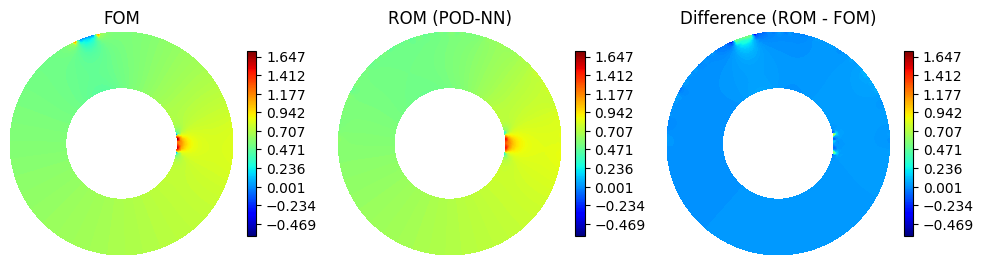

In [71]:
# graphical comparison between FOM and ROM solutions for the first simulation - ROM accuracy

import matplotlib.pyplot as plt

diff = rom_predict(mu[0]) - u[0].detach().cpu().numpy()

# same scale for the different plots and colours - otherwise same values will be mapped into different colours
Vmin = min(u[0].min(), rom_predict(mu[0]).min(), diff.min())
Vmax = max(u[0].max(), rom_predict(mu[0]).max(), diff.max())

clc()

plt.figure(figsize=(10, 4))

# FOM
plt.subplot(1, 3, 1)
fe.plot(u[0], Vh, colorbar=True, shrink=0.5, vmin=Vmin, vmax=Vmax)
plt.title("FOM")

# ROM
plt.subplot(1, 3, 2)
fe.plot(rom_predict(mu[0]), Vh, colorbar=True, shrink=0.5, vmin=Vmin, vmax=Vmax)
plt.title("ROM (POD-NN)")

# Difference between the two
plt.subplot(1, 3, 3)
fe.plot(diff, Vh, colorbar=True, shrink=0.5, vmin=Vmin, vmax=Vmax)
plt.title("Difference (ROM - FOM)")

plt.tight_layout()
plt.show()

In [72]:
# other method to perform the optimization (local optimizer)

num_samples = 50000

# randomly sample parameters within bounds
sampled_theta = np.random.uniform(bounds[0][0], bounds[0][1], num_samples)
sampled_rho1 = np.random.uniform(bounds[1][0], bounds[1][1], num_samples)
sampled_rho2 = np.random.uniform(bounds[2][0], bounds[2][1], num_samples)

mu_matrix = np.column_stack((sampled_theta, sampled_rho1, sampled_rho2))

u_list = []

for mu in mu_matrix:
    u_full = rom_predict(mu)
    u_list.append(u_full)

# Converto in una matrice NumPy: shape (20000, n)
u_matrix = np.vstack(u_list)

u_matrix.shape

(50000, 3899)

In [73]:
error_vector_local = np.zeros(u_matrix.shape[0])

for i in range(u_matrix.shape[0]):
    simulation_values_local = u_matrix[i, sensors_location]  # extract pressure values at sensor locations for the current simulation
    error_vector_local[i] = np.sum((simulation_values_local - sensors_values)**2)  # calculate difference between simulation and real data

best_simulation_local = np.argmin(error_vector_local)  # find simulation with the smallest error
best_mu_local = mu_matrix[best_simulation_local, :]

print('Best simulation is the number ' + str(best_simulation_local) + ', with parameters (theta, p1, p2): ' + str(best_mu_local))
print(f'\nError: {error_vector_local[best_simulation_local]:.6f}')

Best simulation is the number 6801, with parameters (theta, p1, p2): [2.19799325 0.05000206 0.06800084]

Error: 0.000571


In [79]:
from scipy.optimize import minimize
from time import perf_counter

rom_calls = 0  # Reset ROM call counter

# Initial guess: use the parameters found from the sampling step
initial_guess = best_mu_local.tolist()

t0 = perf_counter()  # Start timing the optimization

# Run local optimization
result_local = minimize(
    error_function,
    initial_guess,
    bounds=bounds,
    method='SLSQP',  # SLSQP handles bounds and constraints well
    options={'disp': True}
)

t1 = perf_counter()  # End timing

# Compute improvement compared to the closest precomputed simulation
error_decrease_local = ((error_vector_local[best_simulation_local] - result_local.fun) / error_vector_local[best_simulation_local]) * 100

# Output results
print("\n===== LOCAL OPTIMIZATION RESULTS =====")
print(f"Optimal parameters found:")
print(f"    theta: {result_local.x[0]:.9f} rad")
print(f"    rho1 : {result_local.x[1]:.9f}")
print(f"    rho2 : {result_local.x[2]:.9f}")
print(f"Error: {result_local.fun:.9f}")

print("\n--- Comparison with closest simulation in dataset ---")
print(f"Closest simulation index: {best_simulation}")
print(f"Parameters (theta, rho1, rho2): {best_mu}")
print(f"Error: {error_vector[best_simulation]:.9f}")

print(f"\nROM allowed achieving an error {(error_vector[best_simulation] / result_local.fun):.2f} times smaller")
print(f"Number of ROM evaluations during optimization: {rom_calls}")
print(f"Total optimization time: {t1 - t0:.3f} seconds")
print(f"Average time per ROM evaluation: {(t1 - t0)/rom_calls*1000:.4f} ms")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0004287860083331877
            Iterations: 2
            Function evaluations: 22
            Gradient evaluations: 2

===== LOCAL OPTIMIZATION RESULTS =====
Optimal parameters found:
    theta: 2.197993245 rad
    rho1 : 0.050216586
    rho2 : 0.067923603
Error: 0.000428786

--- Comparison with closest simulation in dataset ---
Closest simulation index: 67
Parameters (theta, rho1, rho2): [2.15479511 0.07729257 0.09294283]
Error: 0.003632724

ROM allowed achieving an error 8.47 times smaller
Number of ROM evaluations during optimization: 22
Total optimization time: 0.020 seconds
Average time per ROM evaluation: 0.9022 ms
